In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : ['t1t2'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(690626, 828)
(690626, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/70 [..............................] - ETA: 1:45 - loss: 0.0760 - STD: 2.1007e-04 - MAE: 0.2658

 4/70 [>.............................] - ETA: 1s - loss: 0.0350 - STD: 3.0688e-04 - MAE: 0.1423  

 5/70 [=>............................] - ETA: 2s - loss: 0.0346 - STD: 2.8172e-04 - MAE: 0.1422

 6/70 [=>............................] - ETA: 2s - loss: 0.0345 - STD: 2.6227e-04 - MAE: 0.1424

 7/70 [==>...........................] - ETA: 2s - loss: 0.0341 - STD: 2.5102e-04 - MAE: 0.1415

 8/70 [==>...........................] - ETA: 2s - loss: 0.0333 - STD: 2.4710e-04 - MAE: 0.1389

 9/70 [==>...........................] - ETA: 2s - loss: 0.0321 - STD: 2.4995e-04 - MAE: 0.1347

10/70 [===>..........................] - ETA: 2s - loss: 0.0308 - STD: 2.5804e-04 - MAE: 0.1290

11/70 [===>..........................] - ETA: 2s - loss: 0.0293 - STD: 2.6968e-04 - MAE: 0.1230

12/70 [====>.........................] - ETA: 2s - loss: 0.0280 - STD: 2.8365e-04 - MAE: 0.1186

13/70 [====>.........................] - ETA: 2s - loss: 0.0270 - STD: 2.9874e-04 - MAE: 0.1167

14/70 [=====>........................] - ETA: 2s - loss: 0.0262 - STD: 3.1292e-04 - MAE: 0.1162

15/70 [=====>........................] - ETA: 4s - loss: 0.0262 - STD: 3.2478e-04 - MAE: 0.1163

18/70 [======>.......................] - ETA: 3s - loss: 0.0246 - STD: 3.6449e-04 - MAE: 0.1157

20/70 [=======>......................] - ETA: 3s - loss: 0.0234 - STD: 3.8538e-04 - MAE: 0.1122

21/70 [========>.....................] - ETA: 3s - loss: 0.0229 - STD: 3.9442e-04 - MAE: 0.1099

22/70 [========>.....................] - ETA: 3s - loss: 0.0225 - STD: 4.0262e-04 - MAE: 0.1078

23/70 [========>.....................] - ETA: 3s - loss: 0.0222 - STD: 4.1052e-04 - MAE: 0.1058

24/70 [=========>....................] - ETA: 3s - loss: 0.0218 - STD: 4.1789e-04 - MAE: 0.1040

25/70 [=========>....................] - ETA: 3s - loss: 0.0216 - STD: 4.2555e-04 - MAE: 0.1024

26/70 [==========>...................] - ETA: 3s - loss: 0.0213 - STD: 4.3375e-04 - MAE: 0.1008

27/70 [==========>...................] - ETA: 2s - loss: 0.0211 - STD: 4.4288e-04 - MAE: 0.0994

28/70 [===========>..................] - ETA: 2s - loss: 0.0208 - STD: 4.5304e-04 - MAE: 0.0980

29/70 [===========>..................] - ETA: 2s - loss: 0.0205 - STD: 4.6488e-04 - MAE: 0.0968

30/70 [===========>..................] - ETA: 2s - loss: 0.0203 - STD: 4.7744e-04 - MAE: 0.0958

31/70 [============>.................] - ETA: 2s - loss: 0.0200 - STD: 4.9161e-04 - MAE: 0.0951

32/70 [============>.................] - ETA: 2s - loss: 0.0198 - STD: 5.0700e-04 - MAE: 0.0946

33/70 [=============>................] - ETA: 2s - loss: 0.0196 - STD: 5.2352e-04 - MAE: 0.0943

34/70 [=============>................] - ETA: 2s - loss: 0.0194 - STD: 5.4072e-04 - MAE: 0.0941

35/70 [==============>...............] - ETA: 2s - loss: 0.0193 - STD: 5.5892e-04 - MAE: 0.0939

36/70 [==============>...............] - ETA: 2s - loss: 0.0191 - STD: 5.7735e-04 - MAE: 0.0937

37/70 [==============>...............] - ETA: 2s - loss: 0.0189 - STD: 5.9610e-04 - MAE: 0.0934

38/70 [===============>..............] - ETA: 2s - loss: 0.0188 - STD: 6.1502e-04 - MAE: 0.0931

39/70 [===============>..............] - ETA: 2s - loss: 0.0186 - STD: 6.3399e-04 - MAE: 0.0926

40/70 [================>.............] - ETA: 1s - loss: 0.0185 - STD: 6.5358e-04 - MAE: 0.0920

41/70 [================>.............] - ETA: 1s - loss: 0.0184 - STD: 6.7337e-04 - MAE: 0.0915

42/70 [=================>............] - ETA: 1s - loss: 0.0182 - STD: 6.9394e-04 - MAE: 0.0908

43/70 [=================>............] - ETA: 1s - loss: 0.0181 - STD: 7.1508e-04 - MAE: 0.0902

44/70 [=================>............] - ETA: 1s - loss: 0.0180 - STD: 7.3742e-04 - MAE: 0.0896

45/70 [==================>...........] - ETA: 1s - loss: 0.0179 - STD: 7.6125e-04 - MAE: 0.0890

46/70 [==================>...........] - ETA: 1s - loss: 0.0178 - STD: 7.8710e-04 - MAE: 0.0885

47/70 [===================>..........] - ETA: 1s - loss: 0.0177 - STD: 8.1482e-04 - MAE: 0.0880

48/70 [===================>..........] - ETA: 1s - loss: 0.0176 - STD: 8.4512e-04 - MAE: 0.0876

49/70 [====================>.........] - ETA: 1s - loss: 0.0175 - STD: 8.7737e-04 - MAE: 0.0873

50/70 [====================>.........] - ETA: 1s - loss: 0.0174 - STD: 9.1301e-04 - MAE: 0.0870

51/70 [====================>.........] - ETA: 1s - loss: 0.0173 - STD: 9.5114e-04 - MAE: 0.0867

52/70 [=====================>........] - ETA: 1s - loss: 0.0172 - STD: 9.9123e-04 - MAE: 0.0865

53/70 [=====================>........] - ETA: 1s - loss: 0.0171 - STD: 0.0010 - MAE: 0.0864    

54/70 [======================>.......] - ETA: 1s - loss: 0.0171 - STD: 0.0011 - MAE: 0.0862

55/70 [======================>.......] - ETA: 0s - loss: 0.0170 - STD: 0.0011 - MAE: 0.0860

56/70 [=======================>......] - ETA: 0s - loss: 0.0169 - STD: 0.0012 - MAE: 0.0858

57/70 [=======================>......] - ETA: 0s - loss: 0.0168 - STD: 0.0012 - MAE: 0.0856

58/70 [=======================>......] - ETA: 0s - loss: 0.0168 - STD: 0.0013 - MAE: 0.0853

59/70 [========================>.....] - ETA: 0s - loss: 0.0167 - STD: 0.0014 - MAE: 0.0850

60/70 [========================>.....] - ETA: 0s - loss: 0.0166 - STD: 0.0014 - MAE: 0.0847

61/70 [=========================>....] - ETA: 0s - loss: 0.0166 - STD: 0.0015 - MAE: 0.0844

62/70 [=========================>....] - ETA: 0s - loss: 0.0165 - STD: 0.0016 - MAE: 0.0841

63/70 [==========================>...] - ETA: 0s - loss: 0.0164 - STD: 0.0017 - MAE: 0.0838

64/70 [==========================>...] - ETA: 0s - loss: 0.0163 - STD: 0.0018 - MAE: 0.0836

65/70 [==========================>...] - ETA: 0s - loss: 0.0163 - STD: 0.0019 - MAE: 0.0833

66/70 [===========================>..] - ETA: 0s - loss: 0.0162 - STD: 0.0020 - MAE: 0.0831

67/70 [===========================>..] - ETA: 0s - loss: 0.0161 - STD: 0.0021 - MAE: 0.0828

68/70 [============================>.] - ETA: 0s - loss: 0.0161 - STD: 0.0022 - MAE: 0.0827

69/70 [============================>.] - ETA: 0s - loss: 0.0160 - STD: 0.0024 - MAE: 0.0825

70/70 [==============================] - ETA: 0s - loss: 0.0159 - STD: 0.0025 - MAE: 0.0823

70/70 [==============================] - 7s 73ms/step - loss: 0.0159 - STD: 0.0025 - MAE: 0.0823 - val_loss: 0.0143 - val_STD: 0.0104 - val_MAE: 0.0757


Epoch 2/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0109 - STD: 0.0145 - MAE: 0.0682

 2/70 [..............................] - ETA: 4s - loss: 0.0108 - STD: 0.0152 - MAE: 0.0673

 3/70 [>.............................] - ETA: 3s - loss: 0.0109 - STD: 0.0159 - MAE: 0.0668

 4/70 [>.............................] - ETA: 3s - loss: 0.0108 - STD: 0.0166 - MAE: 0.0659

 5/70 [=>............................] - ETA: 3s - loss: 0.0108 - STD: 0.0174 - MAE: 0.0651

 6/70 [=>............................] - ETA: 3s - loss: 0.0107 - STD: 0.0183 - MAE: 0.0643

 7/70 [==>...........................] - ETA: 3s - loss: 0.0106 - STD: 0.0192 - MAE: 0.0635

 8/70 [==>...........................] - ETA: 3s - loss: 0.0105 - STD: 0.0202 - MAE: 0.0628

 9/70 [==>...........................] - ETA: 3s - loss: 0.0103 - STD: 0.0212 - MAE: 0.0622

10/70 [===>..........................] - ETA: 3s - loss: 0.0101 - STD: 0.0224 - MAE: 0.0617

11/70 [===>..........................] - ETA: 3s - loss: 0.0100 - STD: 0.0236 - MAE: 0.0613

12/70 [====>.........................] - ETA: 3s - loss: 0.0098 - STD: 0.0249 - MAE: 0.0608

14/70 [=====>........................] - ETA: 2s - loss: 0.0097 - STD: 0.0275 - MAE: 0.0600

15/70 [=====>........................] - ETA: 2s - loss: 0.0095 - STD: 0.0289 - MAE: 0.0593

16/70 [=====>........................] - ETA: 2s - loss: 0.0093 - STD: 0.0302 - MAE: 0.0587

17/70 [======>.......................] - ETA: 2s - loss: 0.0092 - STD: 0.0316 - MAE: 0.0581

18/70 [======>.......................] - ETA: 2s - loss: 0.0090 - STD: 0.0331 - MAE: 0.0575

19/70 [=======>......................] - ETA: 2s - loss: 0.0089 - STD: 0.0346 - MAE: 0.0570

20/70 [=======>......................] - ETA: 2s - loss: 0.0087 - STD: 0.0361 - MAE: 0.0564

21/70 [========>.....................] - ETA: 2s - loss: 0.0085 - STD: 0.0377 - MAE: 0.0559

22/70 [========>.....................] - ETA: 2s - loss: 0.0084 - STD: 0.0393 - MAE: 0.0554

23/70 [========>.....................] - ETA: 2s - loss: 0.0082 - STD: 0.0408 - MAE: 0.0549

24/70 [=========>....................] - ETA: 2s - loss: 0.0081 - STD: 0.0422 - MAE: 0.0544

25/70 [=========>....................] - ETA: 2s - loss: 0.0079 - STD: 0.0435 - MAE: 0.0539

26/70 [==========>...................] - ETA: 2s - loss: 0.0078 - STD: 0.0448 - MAE: 0.0534

27/70 [==========>...................] - ETA: 2s - loss: 0.0077 - STD: 0.0461 - MAE: 0.0529

28/70 [===========>..................] - ETA: 2s - loss: 0.0075 - STD: 0.0474 - MAE: 0.0525

29/70 [===========>..................] - ETA: 2s - loss: 0.0074 - STD: 0.0487 - MAE: 0.0521

30/70 [===========>..................] - ETA: 2s - loss: 0.0073 - STD: 0.0502 - MAE: 0.0517

31/70 [============>.................] - ETA: 2s - loss: 0.0072 - STD: 0.0514 - MAE: 0.0514

32/70 [============>.................] - ETA: 2s - loss: 0.0071 - STD: 0.0526 - MAE: 0.0510

33/70 [=============>................] - ETA: 1s - loss: 0.0070 - STD: 0.0538 - MAE: 0.0506

34/70 [=============>................] - ETA: 1s - loss: 0.0069 - STD: 0.0548 - MAE: 0.0503

35/70 [==============>...............] - ETA: 1s - loss: 0.0068 - STD: 0.0559 - MAE: 0.0499

36/70 [==============>...............] - ETA: 1s - loss: 0.0067 - STD: 0.0571 - MAE: 0.0496

37/70 [==============>...............] - ETA: 1s - loss: 0.0066 - STD: 0.0581 - MAE: 0.0492

38/70 [===============>..............] - ETA: 1s - loss: 0.0065 - STD: 0.0592 - MAE: 0.0489

39/70 [===============>..............] - ETA: 1s - loss: 0.0064 - STD: 0.0601 - MAE: 0.0486

40/70 [================>.............] - ETA: 1s - loss: 0.0064 - STD: 0.0610 - MAE: 0.0483

41/70 [================>.............] - ETA: 1s - loss: 0.0063 - STD: 0.0618 - MAE: 0.0481

42/70 [=================>............] - ETA: 1s - loss: 0.0062 - STD: 0.0627 - MAE: 0.0478

43/70 [=================>............] - ETA: 1s - loss: 0.0062 - STD: 0.0636 - MAE: 0.0476

44/70 [=================>............] - ETA: 1s - loss: 0.0061 - STD: 0.0644 - MAE: 0.0473

45/70 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0651 - MAE: 0.0470

46/70 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0658 - MAE: 0.0468

47/70 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.0666 - MAE: 0.0466

48/70 [===================>..........] - ETA: 1s - loss: 0.0058 - STD: 0.0672 - MAE: 0.0464

49/70 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0679 - MAE: 0.0461

50/70 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0686 - MAE: 0.0459

51/70 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0691 - MAE: 0.0457

52/70 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0697 - MAE: 0.0455

53/70 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0703 - MAE: 0.0453

54/70 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0709 - MAE: 0.0452

55/70 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0714 - MAE: 0.0450

56/70 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0719 - MAE: 0.0448

57/70 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0724 - MAE: 0.0446

58/70 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0729 - MAE: 0.0445

59/70 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0734 - MAE: 0.0443

60/70 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0739 - MAE: 0.0441

61/70 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0743 - MAE: 0.0440

62/70 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0747 - MAE: 0.0438

63/70 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0751 - MAE: 0.0437

64/70 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0755 - MAE: 0.0435

65/70 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0434

66/70 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0764 - MAE: 0.0433

67/70 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0431

68/70 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0771 - MAE: 0.0430

69/70 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0774 - MAE: 0.0429

70/70 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0777 - MAE: 0.0427

70/70 [==============================] - 4s 59ms/step - loss: 0.0049 - STD: 0.0777 - MAE: 0.0427 - val_loss: 0.0037 - val_STD: 0.0784 - val_MAE: 0.0389


Epoch 3/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.1054 - MAE: 0.0340

 2/70 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.1029 - MAE: 0.0339

 3/70 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.1010 - MAE: 0.0339

 4/70 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0339

 5/70 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.1009 - MAE: 0.0338

 6/70 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.1015 - MAE: 0.0337

 7/70 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.1017 - MAE: 0.0337

 8/70 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.1020 - MAE: 0.0337

 9/70 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.1018 - MAE: 0.0336

10/70 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.1018 - MAE: 0.0336

12/70 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.1022 - MAE: 0.0336

13/70 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.1020 - MAE: 0.0335

14/70 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.1015 - MAE: 0.0334

15/70 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.1014 - MAE: 0.0334

16/70 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.1017 - MAE: 0.0333

17/70 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.1020 - MAE: 0.0333

18/70 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.1020 - MAE: 0.0332

19/70 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1020 - MAE: 0.0332

20/70 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0331

21/70 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1019 - MAE: 0.0331

22/70 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1022 - MAE: 0.0331

23/70 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1023 - MAE: 0.0330

24/70 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1022 - MAE: 0.0330

25/70 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1022 - MAE: 0.0330

26/70 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.1024 - MAE: 0.0330

27/70 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.1026 - MAE: 0.0329

28/70 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1025 - MAE: 0.0329

29/70 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1023 - MAE: 0.0328

30/70 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1024 - MAE: 0.0328

31/70 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1025 - MAE: 0.0328

32/70 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1025 - MAE: 0.0327

33/70 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.1025 - MAE: 0.0327

34/70 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.1024 - MAE: 0.0327

35/70 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0326

36/70 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1025 - MAE: 0.0326

37/70 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1026 - MAE: 0.0325

38/70 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1026 - MAE: 0.0325

39/70 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1025 - MAE: 0.0325

40/70 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1026 - MAE: 0.0325

41/70 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1026 - MAE: 0.0324

42/70 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1027 - MAE: 0.0324

43/70 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1027 - MAE: 0.0324

44/70 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1027 - MAE: 0.0323

45/70 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1028 - MAE: 0.0323

47/70 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.1030 - MAE: 0.0322

48/70 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.1030 - MAE: 0.0322

49/70 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1031 - MAE: 0.0322

50/70 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1031 - MAE: 0.0322

51/70 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1031 - MAE: 0.0321

52/70 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1031 - MAE: 0.0321

53/70 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1031 - MAE: 0.0321

54/70 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1031 - MAE: 0.0320

55/70 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1031 - MAE: 0.0320

56/70 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1032 - MAE: 0.0320

57/70 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1033 - MAE: 0.0319

58/70 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1033 - MAE: 0.0319

59/70 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1033 - MAE: 0.0319

60/70 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1033 - MAE: 0.0318

61/70 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1034 - MAE: 0.0318

62/70 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1034 - MAE: 0.0318

63/70 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1034 - MAE: 0.0318

64/70 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1035 - MAE: 0.0317

65/70 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1035 - MAE: 0.0317

66/70 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1035 - MAE: 0.0317

67/70 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1035 - MAE: 0.0316

68/70 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1035 - MAE: 0.0316

69/70 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1036 - MAE: 0.0316

70/70 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1036 - MAE: 0.0315

70/70 [==============================] - 4s 58ms/step - loss: 0.0022 - STD: 0.1036 - MAE: 0.0315 - val_loss: 0.0021 - val_STD: 0.0877 - val_MAE: 0.0314


Epoch 4/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1069 - MAE: 0.0294

 2/70 [..............................] - ETA: 3s - loss: 0.0019 - STD: 0.1058 - MAE: 0.0294

 3/70 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1065 - MAE: 0.0295

 4/70 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1060 - MAE: 0.0295

 5/70 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1062 - MAE: 0.0294

 6/70 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1065 - MAE: 0.0294

 7/70 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1059 - MAE: 0.0294

 8/70 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1062 - MAE: 0.0294

 9/70 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1062 - MAE: 0.0294

10/70 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1062 - MAE: 0.0294

11/70 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1061 - MAE: 0.0293

12/70 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1059 - MAE: 0.0293

13/70 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1063 - MAE: 0.0293

14/70 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1064 - MAE: 0.0293

15/70 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1065 - MAE: 0.0293

16/70 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1064 - MAE: 0.0292

17/70 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1065 - MAE: 0.0292

18/70 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1065 - MAE: 0.0292

19/70 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1064 - MAE: 0.0292

20/70 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1065 - MAE: 0.0292

21/70 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1065 - MAE: 0.0292

22/70 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1065 - MAE: 0.0292

23/70 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1066 - MAE: 0.0292

24/70 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1065 - MAE: 0.0291

25/70 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1066 - MAE: 0.0291

26/70 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1067 - MAE: 0.0291

27/70 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1067 - MAE: 0.0291

28/70 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1066 - MAE: 0.0291

29/70 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1066 - MAE: 0.0291

30/70 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1066 - MAE: 0.0291

31/70 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1066 - MAE: 0.0290

32/70 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1066 - MAE: 0.0290

33/70 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1064 - MAE: 0.0290

34/70 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1065 - MAE: 0.0290

35/70 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1067 - MAE: 0.0290

36/70 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1066 - MAE: 0.0290

37/70 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1067 - MAE: 0.0290

38/70 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1066 - MAE: 0.0290

39/70 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1066 - MAE: 0.0290

41/70 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0290

42/70 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0290

43/70 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0290

44/70 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0289

45/70 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0289

46/70 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0289

47/70 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0289

48/70 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0289

49/70 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0289

50/70 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0288

51/70 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0288

52/70 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0288

53/70 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0288

54/70 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0288

55/70 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0288

56/70 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0288

57/70 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1069 - MAE: 0.0288

58/70 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0288

59/70 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1069 - MAE: 0.0288

60/70 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1069 - MAE: 0.0287

61/70 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0287

62/70 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0287

63/70 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1069 - MAE: 0.0287

64/70 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0287

65/70 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1069 - MAE: 0.0287

66/70 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1069 - MAE: 0.0287

67/70 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1069 - MAE: 0.0287

68/70 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0287

69/70 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0287

70/70 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0287

70/70 [==============================] - 4s 59ms/step - loss: 0.0018 - STD: 0.1068 - MAE: 0.0287 - val_loss: 0.0020 - val_STD: 0.0939 - val_MAE: 0.0305


Epoch 5/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0017 - STD: 0.1084 - MAE: 0.0281

 2/70 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1104 - MAE: 0.0282

 3/70 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1079 - MAE: 0.0283

 4/70 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1086 - MAE: 0.0283

 5/70 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1093 - MAE: 0.0282

 6/70 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1082 - MAE: 0.0282

 7/70 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1079 - MAE: 0.0282

 8/70 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1082 - MAE: 0.0282

 9/70 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0282

10/70 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0282

11/70 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1073 - MAE: 0.0282

12/70 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1070 - MAE: 0.0282

13/70 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1070 - MAE: 0.0281

14/70 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1071 - MAE: 0.0281

15/70 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1069 - MAE: 0.0282

16/70 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1068 - MAE: 0.0282

17/70 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1072 - MAE: 0.0282

18/70 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1071 - MAE: 0.0282

19/70 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1072 - MAE: 0.0282

20/70 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0282

21/70 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1073 - MAE: 0.0282

22/70 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1073 - MAE: 0.0282

23/70 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0282

24/70 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0282

25/70 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0281

26/70 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0281

27/70 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0281

28/70 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1076 - MAE: 0.0281

29/70 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0281

30/70 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1078 - MAE: 0.0281

31/70 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0281

32/70 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0281

33/70 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1078 - MAE: 0.0281

34/70 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0281

35/70 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0280

36/70 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1078 - MAE: 0.0280

37/70 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0280

38/70 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0280

39/70 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0280

40/70 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0280

41/70 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1078 - MAE: 0.0280

42/70 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0280

43/70 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0280

44/70 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1077 - MAE: 0.0280

45/70 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1076 - MAE: 0.0280

46/70 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1076 - MAE: 0.0280

47/70 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0280

48/70 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0280

49/70 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0280

50/70 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1076 - MAE: 0.0280

51/70 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0279

52/70 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0279

53/70 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0279

54/70 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0279

55/70 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0279

56/70 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0279

57/70 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0279

58/70 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0279

59/70 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0279

60/70 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0279

61/70 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0279

62/70 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1076 - MAE: 0.0278

63/70 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0278

64/70 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0278

65/70 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1075 - MAE: 0.0278

66/70 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0278

67/70 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1074 - MAE: 0.0278

69/70 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0278

70/70 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0278

70/70 [==============================] - 4s 60ms/step - loss: 0.0016 - STD: 0.1076 - MAE: 0.0278 - val_loss: 0.0018 - val_STD: 0.0948 - val_MAE: 0.0294


Epoch 6/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0274

 2/70 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0275

 3/70 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1065 - MAE: 0.0275

 4/70 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1068 - MAE: 0.0273

 5/70 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0273

 6/70 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1067 - MAE: 0.0273

 7/70 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1069 - MAE: 0.0273

 8/70 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0273

 9/70 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1067 - MAE: 0.0273

10/70 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1070 - MAE: 0.0273

11/70 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1068 - MAE: 0.0273

12/70 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0274

13/70 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1074 - MAE: 0.0274

14/70 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0274

15/70 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0275

16/70 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0275

17/70 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0275

18/70 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1079 - MAE: 0.0276

19/70 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0277

20/70 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0277

21/70 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1079 - MAE: 0.0276

22/70 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0277

23/70 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0277

24/70 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0277

25/70 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0277

26/70 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0277

27/70 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1079 - MAE: 0.0276

28/70 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0276

29/70 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0276

30/70 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0276

31/70 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0276

32/70 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1079 - MAE: 0.0276

33/70 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0276

34/70 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0276

35/70 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0276

36/70 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1079 - MAE: 0.0276

37/70 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1079 - MAE: 0.0276

38/70 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1079 - MAE: 0.0275

39/70 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1079 - MAE: 0.0275

40/70 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1079 - MAE: 0.0275

41/70 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1079 - MAE: 0.0275

42/70 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0275

43/70 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0275

44/70 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0275

45/70 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0275

46/70 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0275

47/70 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0275

48/70 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0275

49/70 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0275

50/70 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0275

51/70 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0275

52/70 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0275

53/70 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0275

54/70 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0275

55/70 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0275

56/70 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0275

57/70 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0275

58/70 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0275

59/70 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0274

61/70 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0275

62/70 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0276

63/70 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0276

64/70 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0276

65/70 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0277

66/70 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0277

67/70 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0278

68/70 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0278

69/70 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0279

70/70 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0279

70/70 [==============================] - 4s 60ms/step - loss: 0.0016 - STD: 0.1076 - MAE: 0.0279 - val_loss: 0.0018 - val_STD: 0.0938 - val_MAE: 0.0291


Epoch 7/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0271

 2/70 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0291

 3/70 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0283

 4/70 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1063 - MAE: 0.0291

 5/70 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0287

 6/70 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0289

 7/70 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0286

 8/70 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1066 - MAE: 0.0288

 9/70 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1066 - MAE: 0.0286

10/70 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0286

11/70 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0285

12/70 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1069 - MAE: 0.0284

13/70 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1068 - MAE: 0.0283

14/70 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0283

15/70 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1066 - MAE: 0.0282

16/70 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1068 - MAE: 0.0282

17/70 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1067 - MAE: 0.0281

18/70 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1065 - MAE: 0.0281

19/70 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1067 - MAE: 0.0281

20/70 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1070 - MAE: 0.0281

21/70 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1071 - MAE: 0.0280

22/70 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1070 - MAE: 0.0280

23/70 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1071 - MAE: 0.0279

24/70 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1071 - MAE: 0.0279

25/70 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1072 - MAE: 0.0279

26/70 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1071 - MAE: 0.0278

28/70 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0279

29/70 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1074 - MAE: 0.0279

30/70 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1074 - MAE: 0.0278

31/70 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1074 - MAE: 0.0278

32/70 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1074 - MAE: 0.0278

33/70 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1073 - MAE: 0.0278

34/70 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1073 - MAE: 0.0277

35/70 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1073 - MAE: 0.0277

36/70 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1074 - MAE: 0.0277

37/70 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1073 - MAE: 0.0277

38/70 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1074 - MAE: 0.0276

39/70 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1074 - MAE: 0.0276

40/70 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1073 - MAE: 0.0276

41/70 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1074 - MAE: 0.0276

42/70 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1074 - MAE: 0.0276

43/70 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1074 - MAE: 0.0276

44/70 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1074 - MAE: 0.0275

45/70 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0275

46/70 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0275

47/70 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0275

48/70 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0275

49/70 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0275

50/70 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0275

51/70 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0275

52/70 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0274

53/70 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0274

54/70 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0274

55/70 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0274

56/70 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0274

57/70 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0274

58/70 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0274

59/70 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0274

60/70 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0273

61/70 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0273

62/70 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0273

63/70 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0273

64/70 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0273

65/70 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0273

66/70 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0273

67/70 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0273

68/70 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0273

69/70 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0272

70/70 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0272

70/70 [==============================] - 4s 60ms/step - loss: 0.0016 - STD: 0.1078 - MAE: 0.0272 - val_loss: 0.0017 - val_STD: 0.0953 - val_MAE: 0.0288


Epoch 8/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0267

 2/70 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1077 - MAE: 0.0267

 3/70 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1072 - MAE: 0.0266

 4/70 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1077 - MAE: 0.0266

 5/70 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0267

 6/70 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0268

 7/70 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0268

 8/70 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0268

 9/70 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0268

10/70 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0268

11/70 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0268

12/70 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0268

13/70 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0268

14/70 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0268

15/70 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0268

16/70 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0268

17/70 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0268

18/70 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0268

19/70 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0268

20/70 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0268

21/70 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0268

22/70 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0267

23/70 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0267

24/70 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0267

25/70 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0267

26/70 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

27/70 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0268

29/70 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0268

30/70 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0268

31/70 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0268

32/70 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

33/70 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

34/70 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

35/70 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

36/70 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

37/70 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

38/70 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

39/70 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

40/70 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

41/70 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

42/70 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0268

43/70 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

44/70 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0268

45/70 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

46/70 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

47/70 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

48/70 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

49/70 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

50/70 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

51/70 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0267

52/70 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0267

53/70 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0267

54/70 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0268

55/70 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0268

56/70 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0268

57/70 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0268

58/70 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0268

59/70 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0268

60/70 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0268

61/70 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

62/70 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0268

63/70 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0268

64/70 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

65/70 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0268

66/70 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0268

67/70 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

68/70 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

69/70 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

70/70 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0268

70/70 [==============================] - 4s 59ms/step - loss: 0.0015 - STD: 0.1082 - MAE: 0.0268 - val_loss: 0.0016 - val_STD: 0.0940 - val_MAE: 0.0281


Epoch 9/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1073 - MAE: 0.0272

 2/70 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0269

 3/70 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1079 - MAE: 0.0269

 4/70 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1072 - MAE: 0.0270

 5/70 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0269

 6/70 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1076 - MAE: 0.0270

 7/70 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1073 - MAE: 0.0271

 8/70 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1074 - MAE: 0.0270

 9/70 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0271

10/70 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1074 - MAE: 0.0272

11/70 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0272

12/70 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0272

13/70 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0272

14/70 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1074 - MAE: 0.0271

15/70 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0272

16/70 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0272

17/70 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1078 - MAE: 0.0271

18/70 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0272

19/70 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0272

20/70 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0271

21/70 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0271

22/70 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0271

23/70 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0271

24/70 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0271

25/70 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0270

26/70 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0270

27/70 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0270

28/70 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0270

29/70 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0270

30/70 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0270

31/70 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0270

32/70 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0270

33/70 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0270

34/70 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0269

35/70 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0269

36/70 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0269

37/70 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0269

38/70 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0269

39/70 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0269

40/70 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0269

41/70 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0269

42/70 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0269

43/70 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0268

44/70 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0268

45/70 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1079 - MAE: 0.0268

46/70 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1079 - MAE: 0.0268

47/70 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0268

48/70 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0268

49/70 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

50/70 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

51/70 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

52/70 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

53/70 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

54/70 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

55/70 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

56/70 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0268

57/70 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0268

58/70 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0268

59/70 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0268

60/70 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0268

61/70 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0268

62/70 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0268

63/70 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0268

64/70 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0268

65/70 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0268

66/70 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0268

67/70 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0268

68/70 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0268

70/70 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0268

70/70 [==============================] - 4s 59ms/step - loss: 0.0015 - STD: 0.1082 - MAE: 0.0268 - val_loss: 0.0018 - val_STD: 0.0965 - val_MAE: 0.0295


Epoch 10/10000


 1/70 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1126 - MAE: 0.0268

 2/70 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1099 - MAE: 0.0267

 3/70 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1092 - MAE: 0.0266

 4/70 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1089 - MAE: 0.0266

 5/70 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1090 - MAE: 0.0266

 6/70 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1090 - MAE: 0.0266

 7/70 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1098 - MAE: 0.0266

 8/70 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1091 - MAE: 0.0267

 9/70 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1092 - MAE: 0.0267

10/70 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1092 - MAE: 0.0266

11/70 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1089 - MAE: 0.0266

12/70 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1089 - MAE: 0.0266

13/70 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0266

14/70 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0267

15/70 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0266

16/70 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0266

17/70 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0267

18/70 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0267

19/70 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0267

20/70 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0267

21/70 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0267

23/70 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1090 - MAE: 0.0267

24/70 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1089 - MAE: 0.0267

25/70 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1090 - MAE: 0.0267

26/70 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1092 - MAE: 0.0267

27/70 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1089 - MAE: 0.0267

28/70 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0267

29/70 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1089 - MAE: 0.0267

30/70 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0268

31/70 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0268

32/70 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1090 - MAE: 0.0268

33/70 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1089 - MAE: 0.0269

34/70 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0269

35/70 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1090 - MAE: 0.0269

36/70 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0270

37/70 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0270

38/70 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1089 - MAE: 0.0271

39/70 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0271

40/70 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0271

41/70 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1089 - MAE: 0.0272

42/70 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0272

43/70 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1087 - MAE: 0.0272

44/70 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1088 - MAE: 0.0273

45/70 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1087 - MAE: 0.0273

46/70 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1086 - MAE: 0.0273

47/70 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1087 - MAE: 0.0273

48/70 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1087 - MAE: 0.0273

49/70 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1085 - MAE: 0.0273

50/70 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1084 - MAE: 0.0272

51/70 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1085 - MAE: 0.0272

52/70 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1085 - MAE: 0.0272

53/70 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1084 - MAE: 0.0272

54/70 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1084 - MAE: 0.0272

55/70 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1085 - MAE: 0.0272

56/70 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1084 - MAE: 0.0272

57/70 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1085 - MAE: 0.0272

58/70 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1085 - MAE: 0.0272

59/70 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0272

60/70 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0272

61/70 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0272

62/70 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0272

63/70 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0271

64/70 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0271

65/70 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0271

66/70 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0271

67/70 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0271

68/70 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0271

69/70 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0271

70/70 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0271

70/70 [==============================] - 5s 65ms/step - loss: 0.0015 - STD: 0.1084 - MAE: 0.0271 - val_loss: 0.0017 - val_STD: 0.0961 - val_MAE: 0.0286


Epoch 11/10000


 1/70 [..............................] - ETA: 7s - loss: 0.0014 - STD: 0.1076 - MAE: 0.0258

 2/70 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0261

 3/70 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0261

 4/70 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1076 - MAE: 0.0264

 5/70 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1074 - MAE: 0.0263

 6/70 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0262

 7/70 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1072 - MAE: 0.0263

 8/70 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1074 - MAE: 0.0262

 9/70 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1074 - MAE: 0.0262

10/70 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1076 - MAE: 0.0262

11/70 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1077 - MAE: 0.0262

12/70 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1075 - MAE: 0.0262

13/70 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1077 - MAE: 0.0262

14/70 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1079 - MAE: 0.0262

15/70 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1079 - MAE: 0.0263

16/70 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0262

17/70 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0263

18/70 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0263

19/70 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0263

20/70 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0263

21/70 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0262

22/70 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0263

23/70 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0263

24/70 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0263

25/70 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0263

26/70 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0263

27/70 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0263

28/70 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0263

29/70 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0263

30/70 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0263

31/70 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0263

32/70 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0263

33/70 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0263

34/70 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0263

35/70 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0263

36/70 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0263

37/70 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0263

38/70 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0263

39/70 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0263

40/70 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0263

41/70 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0264

42/70 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0264

43/70 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0264

44/70 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

45/70 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0264

46/70 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

47/70 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0263

49/70 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0264

50/70 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0264

51/70 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

52/70 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

53/70 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

54/70 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

55/70 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

56/70 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

57/70 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

58/70 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

59/70 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0264

60/70 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

61/70 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

62/70 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

63/70 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

64/70 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

65/70 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

66/70 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

67/70 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

68/70 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

69/70 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

70/70 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

70/70 [==============================] - 4s 61ms/step - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264 - val_loss: 0.0017 - val_STD: 0.0966 - val_MAE: 0.0285


Epoch 12/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1094 - MAE: 0.0260

 2/70 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1100 - MAE: 0.0262

 3/70 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1094 - MAE: 0.0261

 4/70 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1088 - MAE: 0.0261

 5/70 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1082 - MAE: 0.0261

 6/70 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1081 - MAE: 0.0261

 7/70 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1080 - MAE: 0.0261

 8/70 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1077 - MAE: 0.0261

 9/70 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1077 - MAE: 0.0261

10/70 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1080 - MAE: 0.0261

11/70 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1083 - MAE: 0.0261

13/70 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1086 - MAE: 0.0262

14/70 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1085 - MAE: 0.0263

15/70 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1085 - MAE: 0.0262

16/70 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1086 - MAE: 0.0262

17/70 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1086 - MAE: 0.0262

18/70 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1084 - MAE: 0.0262

19/70 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1085 - MAE: 0.0262

20/70 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1084 - MAE: 0.0262

21/70 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1085 - MAE: 0.0262

22/70 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1085 - MAE: 0.0262

23/70 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1084 - MAE: 0.0262

24/70 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1084 - MAE: 0.0262

25/70 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1084 - MAE: 0.0262

26/70 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1083 - MAE: 0.0262

27/70 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1083 - MAE: 0.0262

28/70 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1084 - MAE: 0.0262

29/70 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1083 - MAE: 0.0262

30/70 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1083 - MAE: 0.0262

31/70 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1083 - MAE: 0.0262

32/70 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1082 - MAE: 0.0262

33/70 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1082 - MAE: 0.0262

34/70 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1082 - MAE: 0.0262

35/70 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1082 - MAE: 0.0262

36/70 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1083 - MAE: 0.0262

37/70 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1083 - MAE: 0.0262

38/70 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1083 - MAE: 0.0262

39/70 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1082 - MAE: 0.0262

40/70 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1082 - MAE: 0.0262

41/70 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1081 - MAE: 0.0262

42/70 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1081 - MAE: 0.0262

43/70 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1082 - MAE: 0.0262

44/70 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1082 - MAE: 0.0262

45/70 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1082 - MAE: 0.0262

46/70 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1083 - MAE: 0.0262

47/70 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1083 - MAE: 0.0262

48/70 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1084 - MAE: 0.0262

49/70 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1084 - MAE: 0.0262

50/70 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1084 - MAE: 0.0262

51/70 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1084 - MAE: 0.0262

52/70 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1084 - MAE: 0.0262

53/70 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1084 - MAE: 0.0262

54/70 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1084 - MAE: 0.0262

55/70 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1084 - MAE: 0.0263

56/70 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1085 - MAE: 0.0263

57/70 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0263

58/70 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0263

59/70 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0263

60/70 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0263

61/70 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0264

62/70 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0264

63/70 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0264

64/70 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0264

65/70 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0264

66/70 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

67/70 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

68/70 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

69/70 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

70/70 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

70/70 [==============================] - 4s 62ms/step - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264 - val_loss: 0.0018 - val_STD: 0.0960 - val_MAE: 0.0293


Epoch 13/10000


 1/70 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0264

 2/70 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

 3/70 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0263

 4/70 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1075 - MAE: 0.0262

 5/70 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1071 - MAE: 0.0263

 6/70 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1076 - MAE: 0.0262

 7/70 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0263

 8/70 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0264

 9/70 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0263

10/70 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0264

11/70 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0264

12/70 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

13/70 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

14/70 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0263

15/70 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0263

16/70 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0263

17/70 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0263

18/70 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0263

20/70 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0263

21/70 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0263

22/70 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1084 - MAE: 0.0263

23/70 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0263

24/70 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0263

25/70 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1086 - MAE: 0.0263

26/70 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0263

27/70 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0263

28/70 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0263

29/70 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0263

30/70 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0264

31/70 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0264

32/70 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0264

33/70 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0264

34/70 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0264

35/70 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0264

36/70 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0264

37/70 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0264

38/70 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

39/70 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

40/70 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0264

41/70 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0264

42/70 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0264

43/70 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0264

44/70 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0264

45/70 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

46/70 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

47/70 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

48/70 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0264

49/70 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0264

50/70 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

51/70 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

52/70 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

53/70 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

54/70 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

55/70 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

56/70 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

57/70 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

58/70 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

59/70 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

60/70 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0264

61/70 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0264

62/70 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0264

63/70 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0263

64/70 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0264

65/70 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0264

66/70 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0264

67/70 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

68/70 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0264

69/70 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0264

70/70 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0264

70/70 [==============================] - 4s 62ms/step - loss: 0.0015 - STD: 0.1085 - MAE: 0.0264 - val_loss: 0.0016 - val_STD: 0.0961 - val_MAE: 0.0280


Epoch 14/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0258

 2/70 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0264

 3/70 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1092 - MAE: 0.0268

 4/70 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0272

 5/70 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0270

 6/70 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0269

 7/70 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0271

 8/70 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0270

 9/70 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0269

10/70 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0270

11/70 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0270

12/70 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0269

13/70 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0269

14/70 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0269

15/70 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0268

16/70 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0268

17/70 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0268

18/70 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0267

19/70 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0267

20/70 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0267

21/70 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0267

22/70 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0267

23/70 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0267

25/70 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0266

26/70 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0265

27/70 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0265

28/70 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0265

29/70 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0265

30/70 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0265

31/70 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0265

32/70 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0265

33/70 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0265

34/70 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0265

35/70 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0265

36/70 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0265

37/70 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0265

38/70 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0264

39/70 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0264

40/70 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0264

41/70 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

42/70 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

43/70 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

44/70 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

45/70 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

46/70 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0264

47/70 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

48/70 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

49/70 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

50/70 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0264

51/70 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

52/70 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

53/70 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0263

54/70 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0263

55/70 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

56/70 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

57/70 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

58/70 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0264

59/70 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

60/70 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

61/70 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0264

62/70 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0263

63/70 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0263

64/70 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0263

65/70 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0263

66/70 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0263

67/70 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0263

68/70 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0263

69/70 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0263

70/70 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0263

70/70 [==============================] - 4s 62ms/step - loss: 0.0015 - STD: 0.1087 - MAE: 0.0263 - val_loss: 0.0017 - val_STD: 0.0968 - val_MAE: 0.0285


Epoch 15/10000


 1/70 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1085 - MAE: 0.0259

 3/70 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1094 - MAE: 0.0269

 4/70 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0270

 5/70 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1085 - MAE: 0.0267

 6/70 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1086 - MAE: 0.0268

 7/70 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1075 - MAE: 0.0271

 8/70 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1079 - MAE: 0.0269

 9/70 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0269

10/70 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1075 - MAE: 0.0271

11/70 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1076 - MAE: 0.0270

12/70 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1078 - MAE: 0.0269

13/70 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1077 - MAE: 0.0269

14/70 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1078 - MAE: 0.0268

15/70 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1078 - MAE: 0.0267

16/70 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1078 - MAE: 0.0267

17/70 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0267

18/70 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1079 - MAE: 0.0266

19/70 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1079 - MAE: 0.0266

20/70 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1078 - MAE: 0.0266

21/70 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1079 - MAE: 0.0265

22/70 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0265

23/70 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1079 - MAE: 0.0265

24/70 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1079 - MAE: 0.0265

25/70 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0264

26/70 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1079 - MAE: 0.0264

27/70 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1080 - MAE: 0.0264

28/70 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1081 - MAE: 0.0264

29/70 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1081 - MAE: 0.0264

30/70 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1081 - MAE: 0.0264

31/70 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0264

32/70 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1083 - MAE: 0.0263

33/70 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1082 - MAE: 0.0263

34/70 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1083 - MAE: 0.0263

35/70 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1083 - MAE: 0.0263

36/70 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1084 - MAE: 0.0263

37/70 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1084 - MAE: 0.0263

38/70 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1084 - MAE: 0.0263

39/70 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0263

40/70 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1084 - MAE: 0.0263

41/70 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1084 - MAE: 0.0263

42/70 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1085 - MAE: 0.0263

43/70 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1085 - MAE: 0.0263

44/70 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1086 - MAE: 0.0263

45/70 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1085 - MAE: 0.0263

46/70 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1085 - MAE: 0.0263

47/70 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1084 - MAE: 0.0263

48/70 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1084 - MAE: 0.0262

49/70 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1084 - MAE: 0.0262

50/70 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1084 - MAE: 0.0262

51/70 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1084 - MAE: 0.0262

52/70 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1084 - MAE: 0.0262

53/70 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1085 - MAE: 0.0262

54/70 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1086 - MAE: 0.0262

55/70 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1086 - MAE: 0.0262

56/70 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1086 - MAE: 0.0262

57/70 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1086 - MAE: 0.0262

58/70 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1087 - MAE: 0.0263

59/70 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1087 - MAE: 0.0263

60/70 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1087 - MAE: 0.0262

61/70 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1087 - MAE: 0.0262

62/70 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1087 - MAE: 0.0262

63/70 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1087 - MAE: 0.0262

64/70 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1087 - MAE: 0.0262

65/70 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1087 - MAE: 0.0262

66/70 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1087 - MAE: 0.0262

67/70 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1086 - MAE: 0.0262

68/70 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1086 - MAE: 0.0262

69/70 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1086 - MAE: 0.0262

70/70 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1086 - MAE: 0.0263

70/70 [==============================] - 4s 62ms/step - loss: 0.0014 - STD: 0.1086 - MAE: 0.0263 - val_loss: 0.0022 - val_STD: 0.1004 - val_MAE: 0.0319


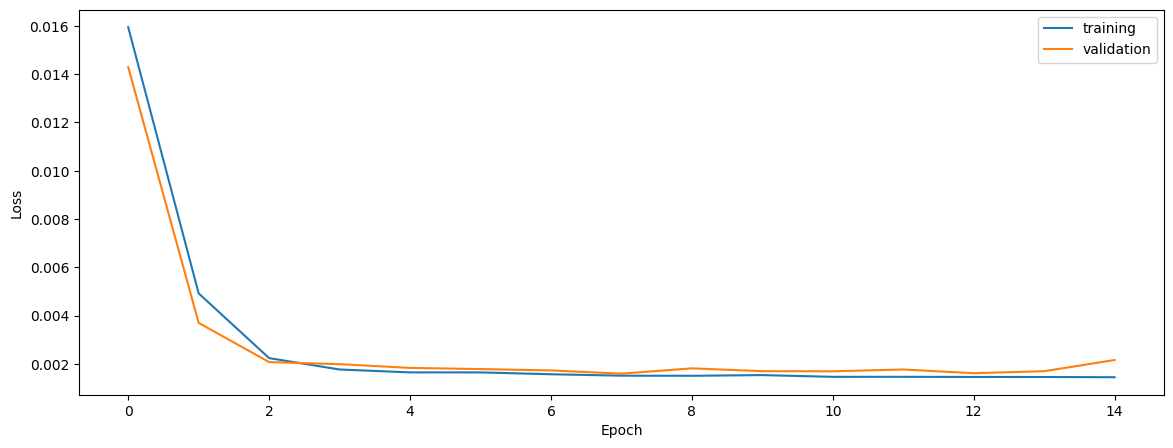

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.9424490336622295
0.9518952492724772
0.949259624636337


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.9431387216833289
0.9504882475736371
0.9494433092686018


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.9508725643433094
0.952880462046199
0.96155751287043


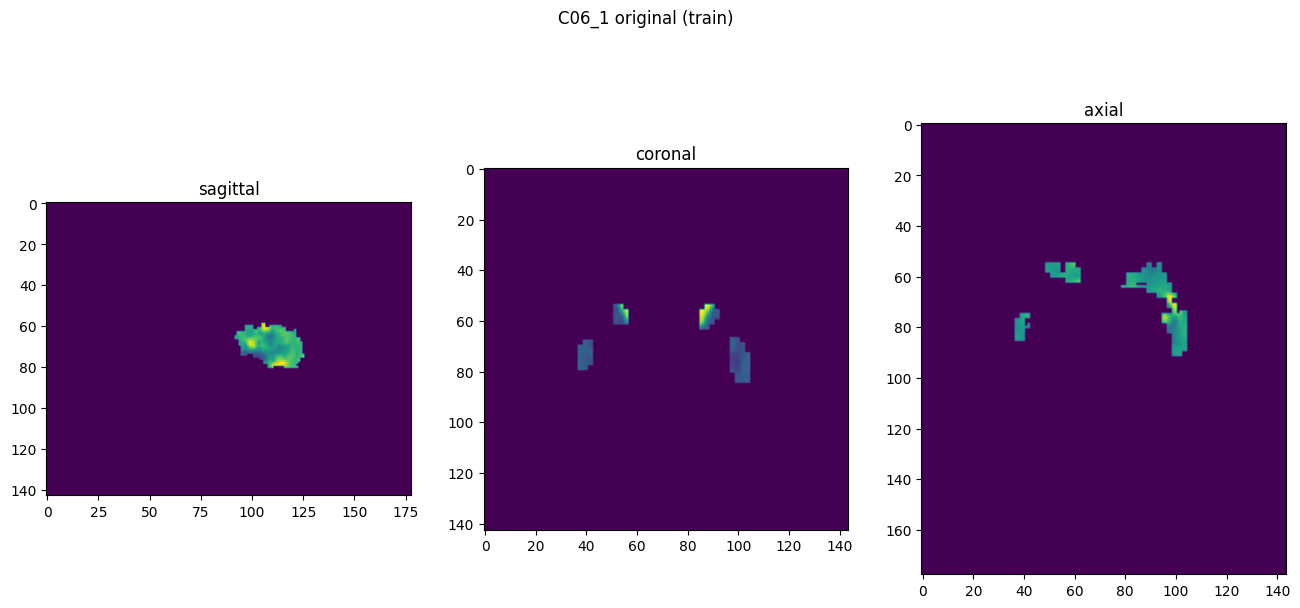

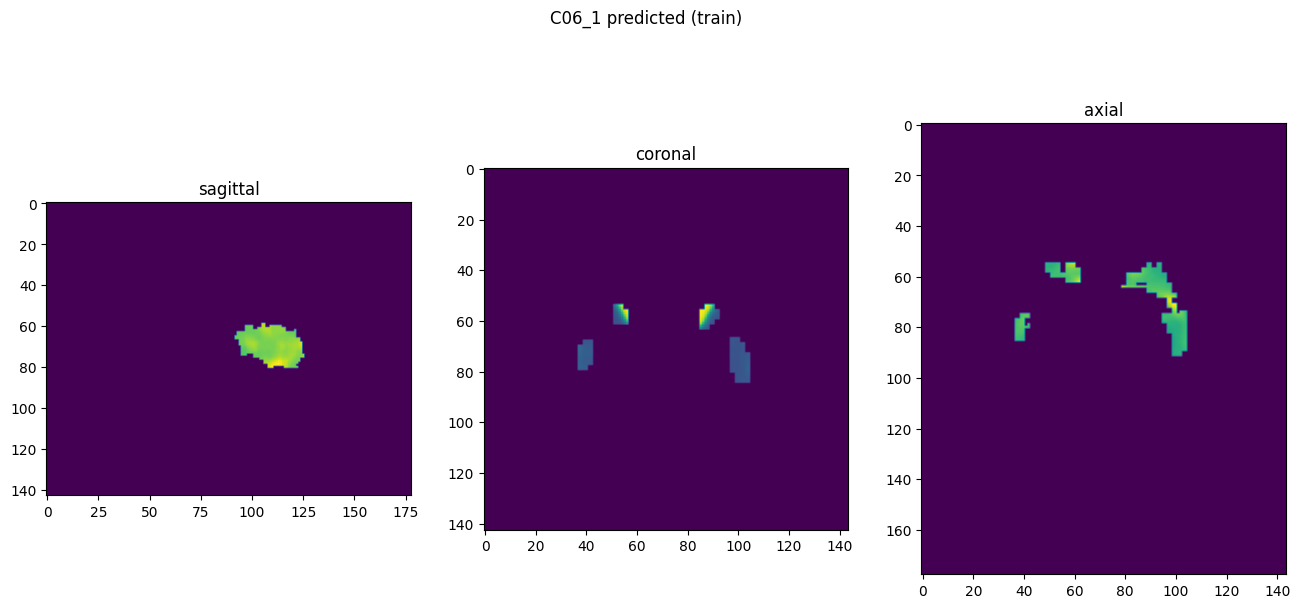

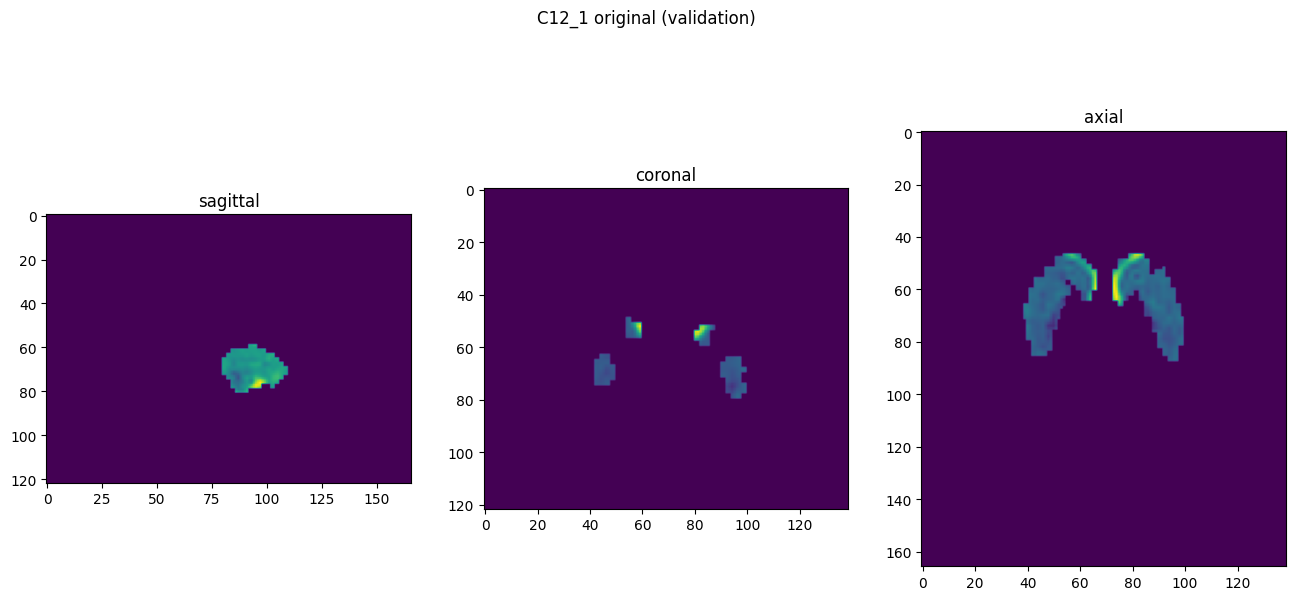

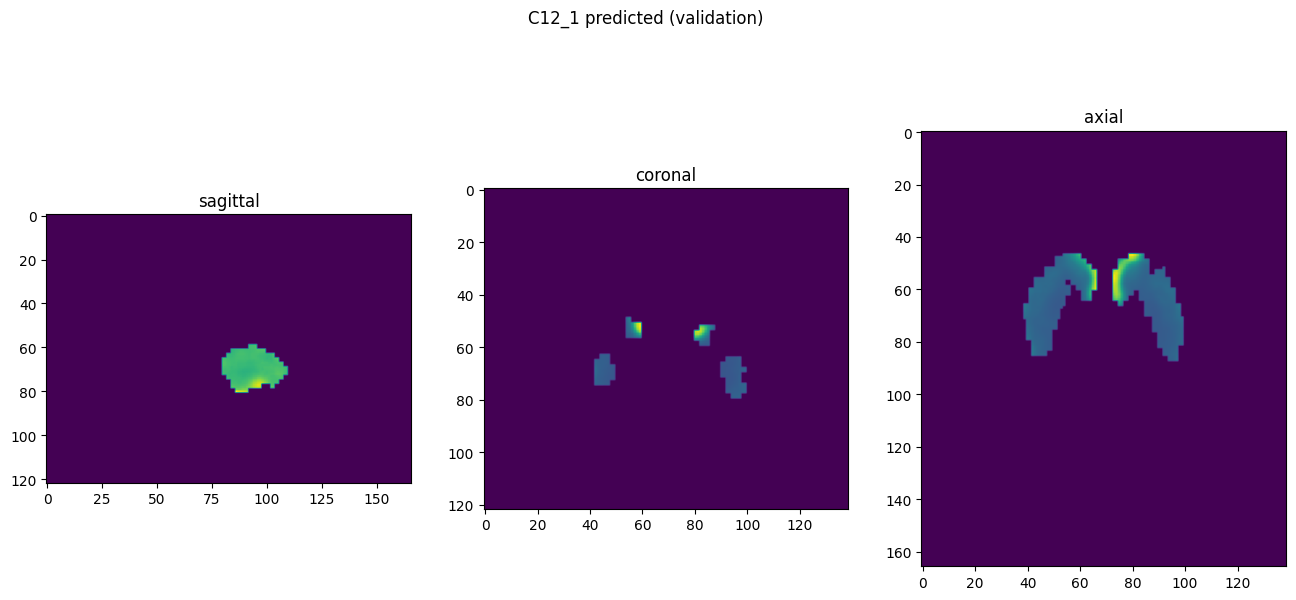

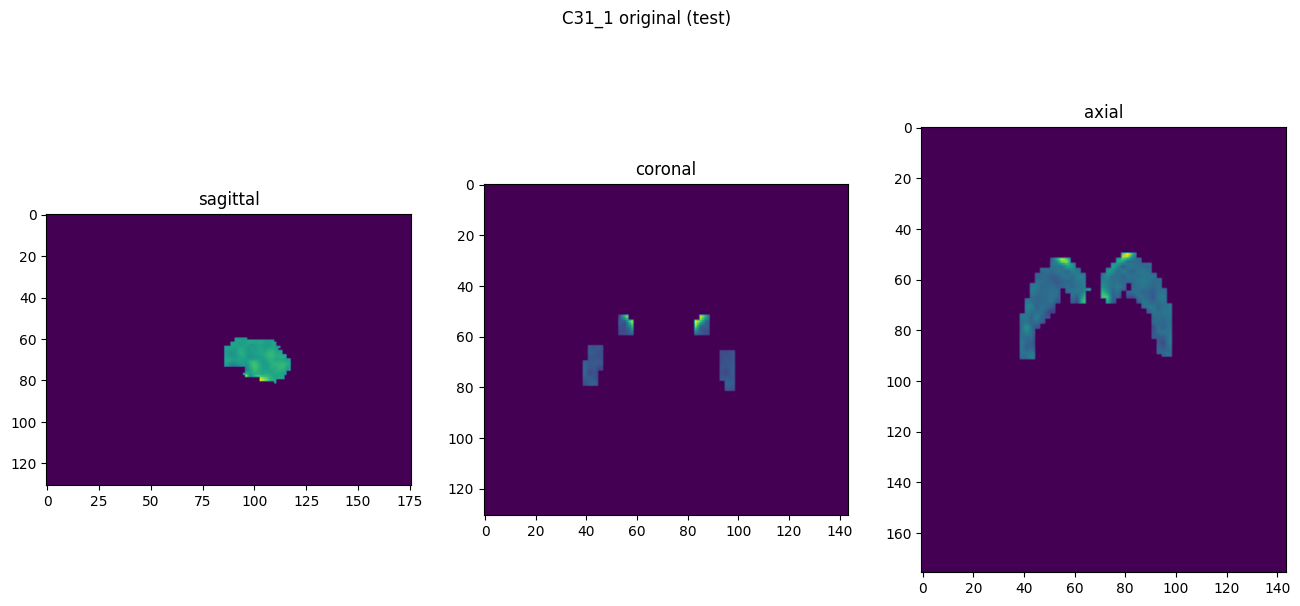

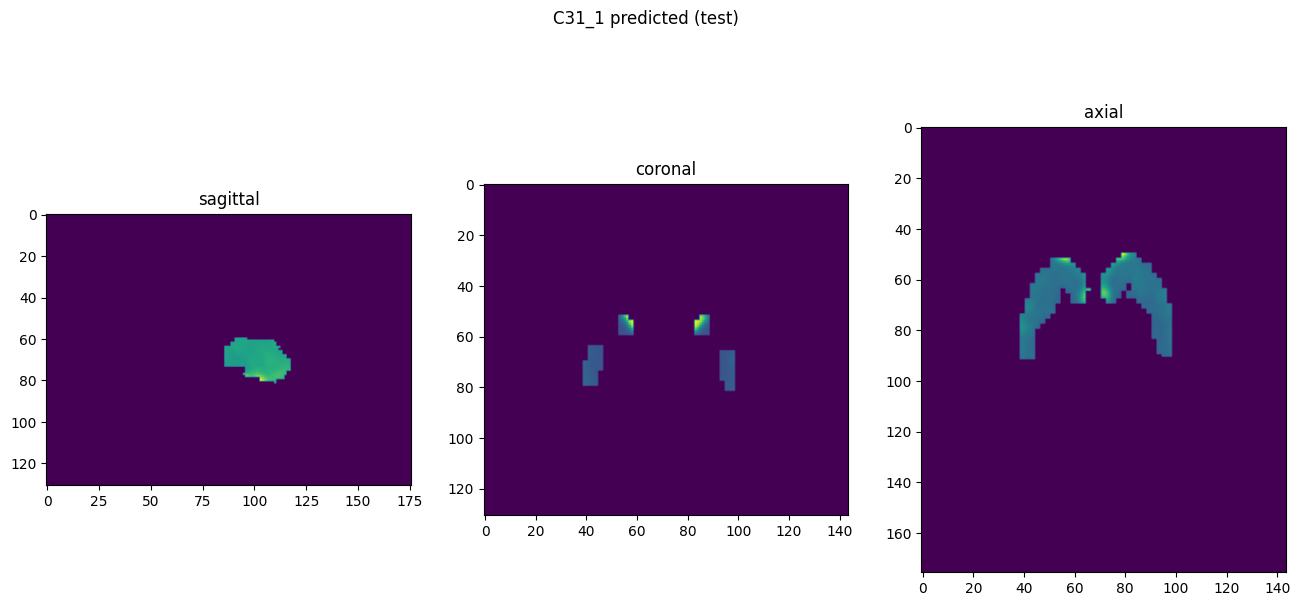

In [10]:
showResults(model, gen, threshold=None, background=False)